<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso,Ridge,RidgeCV,LassoCV,LinearRegression
from math import log, exp, sqrt
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score,cross_val_predict

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

#### 1.1  Check Shape and Head of Data House

In [3]:
# A:
house.shape

(1460, 81)

In [4]:
# displaying all the columns.
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Looking at the column names:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### 1.2  Setting the 'Id' as Index

In [6]:
#Setting 'ID' as 'Index'
house.set_index(keys='Id',inplace=True)

#### 1.3 Droped all the Non-Residential house from the dataset i.e. A,C and I

In [7]:
#removed the houses that are not residential from the dataset (e.g. A,C and I)
house = house[house['MSZoning'].isin(['FV','RH','RL','RP','RM'])]

#### 1.4 Dealing with Null Values 

In [8]:
# Checking the columns having null values
null = pd.DataFrame(house.isnull().sum())   
for i , col in null.items():
    print(col[col != 0])

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
Name: 0, dtype: int64


###### As we can see above that there are 19 columns with null values 

The data have 19 features with nulls, five of then area categorical and with more then 47% of missing ration.
1. PoolQC
2. MiscFeature
3. Alley
4. Fence
5. FireplaceQu

In [9]:
# returns and drops list of columns with more than 40% null values
null_columns = house.columns[house.isnull().sum() > len(house)*0.4]
null_columns

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [10]:
house.drop(null_columns, axis=1, inplace=True)

In [11]:
#Replacing the numeric NaN value with Median
house['LotFrontage'].fillna(house.LotFrontage.median(),inplace = True )
house['MasVnrArea'].fillna(house.MasVnrArea.median(),inplace = True )
house['GarageYrBlt'].fillna(house.GarageYrBlt.median(),inplace = True )

#Replacing string values with NA
house['MasVnrType'].replace(np.nan,'NA', inplace= True)
house['BsmtQual'].replace(np.nan,'NA' , inplace= True)
house['BsmtCond'].replace(np.nan,'NA' , inplace= True)
house['BsmtExposure'].replace(np.nan,'NA', inplace= True)
house['BsmtFinType1'].replace(np.nan,'NA' , inplace= True)
house['BsmtFinType2'].replace(np.nan,'NA', inplace= True)
house['GarageType'].replace(np.nan,'NA' , inplace= True)
house['GarageFinish'].replace(np.nan,'NA', inplace= True)
house['GarageQual'].replace(np.nan,'NA', inplace= True)
house['GarageCond'].replace(np.nan,'NA', inplace= True)

In [12]:
# There were no relevant information regarding a single row with missing 'Electrical' information 
# so droped that particular column
house.dropna(subset= ['Electrical'],inplace = True)

In [13]:
house.shape

(1449, 75)

In [14]:
# all Clean
house.columns[house.isnull().sum()>0]

Index([], dtype='object')

#### 1.5 Fixing the Datatypes 

In [15]:
# Converting the GarageYrBlt to int from float.
house['GarageYrBlt']= house['GarageYrBlt'].astype(int)

In [16]:
# Converting all the columns representing the area to float.
house['LotArea']= house['LotArea'].astype(float)
house['GrLivArea']= house['GrLivArea'].astype(float)
house['GarageArea']= house['GarageArea'].astype(float)
house['PoolArea']= house['PoolArea'].astype(float)

#### 1.6 Renaming the Column names

In [17]:
house.rename(columns = {'1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecondFlrSF', '3SsnPorch':'ThreeSsnPorch'}, inplace = True)

#### 1.7 Looking for Numeric data in our Dataset and looking for mean and quartiles

In [18]:
house.columns[(house.dtypes == 'int' )|(house.dtypes == 'float64' )]

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [19]:
numeric_col = house.loc[:,['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
                           'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                           'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF',
                           'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                           'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                           'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                           'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
                           'MoSold', 'YrSold', 'SalePrice']]

In [20]:
numeric_col.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1449.0,56.887509,42.275264,20.0,20.0,50.0,70.0,190.0
LotFrontage,1449.0,70.041408,22.029825,21.0,60.0,70.0,79.0,313.0
LotArea,1449.0,10524.376121,10015.620536,1300.0,7540.0,9492.0,11616.0,215245.0
OverallQual,1449.0,6.115252,1.373022,1.0,5.0,6.0,7.0,10.0
OverallCond,1449.0,5.582471,1.107606,1.0,5.0,5.0,6.0,9.0
YearBuilt,1449.0,1971.569358,30.019438,1872.0,1954.0,1973.0,2001.0,2010.0
YearRemodAdd,1449.0,1985.034507,20.551315,1950.0,1967.0,1994.0,2004.0,2010.0
MasVnrArea,1449.0,103.899931,181.192098,0.0,0.0,0.0,166.0,1600.0
BsmtFinSF1,1449.0,445.469979,456.361401,0.0,0.0,384.0,714.0,5644.0
BsmtFinSF2,1449.0,46.902692,161.879639,0.0,0.0,0.0,0.0,1474.0


#### 1.8 Skew of Univariate Distributions

In [21]:
house.skew()

MSSubClass        1.401177
LotFrontage       2.392850
LotArea          12.171934
OverallQual       0.235905
OverallCond       0.725539
YearBuilt        -0.625629
YearRemodAdd     -0.513639
MasVnrArea        2.665880
BsmtFinSF1        1.686586
BsmtFinSF2        4.236882
BsmtUnfSF         0.921341
TotalBsmtSF       1.523152
FirstFlrSF        1.377229
SecondFlrSF       0.812784
LowQualFinSF      9.234379
GrLivArea         1.372557
BsmtFullBath      0.586904
BsmtHalfBath      4.117362
FullBath          0.038720
HalfBath          0.670179
BedroomAbvGr      0.211430
KitchenAbvGr      4.509267
TotRmsAbvGrd      0.678944
Fireplaces        0.640789
GarageYrBlt      -0.667839
GarageCars       -0.341978
GarageArea        0.162017
WoodDeckSF        1.531871
OpenPorchSF       2.232804
EnclosedPorch     3.140533
ThreeSsnPorch    10.264483
ScreenPorch       4.114696
PoolArea         14.771759
MiscVal          24.413347
MoSold            0.218617
YrSold            0.098607
SalePrice         1.907456
d

#### 1.8 Correlation Matrix

In [22]:
numeric_col.corr().loc[:,['SalePrice']].T

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
SalePrice,-0.087429,0.33759,0.264709,0.789119,-0.089159,0.517984,0.501521,0.471044,0.384485,-0.014181,0.216116,0.612405,0.603411,0.31991,-0.01877,0.70865,0.224007,-0.017591,0.556895,0.281181,0.162031,-0.137854,0.533413,0.463298,0.467583,0.642201,0.629822,0.320779,0.329464,-0.120815,0.043794,0.110511,0.092389,-0.021063,0.051932,-0.025374,1.0


#### Sale price is highly correlated with 
    OverallQual 
    YearBuilt
    YearRemodAdd
    TotalBsmtSF
    FirstFlrSF
    GrLivArea
    FullBath
    TotRmsAbvGrd
    GarageCars
    GarageArea
    
    #It looks like variables such as overall quality, garage size, total floor area on 1st flr, basement area,
    #number of full baths, and the year built/remodeled are most indicative of a higher sale price.

In [23]:
house.groupby(['OverallQual'])['SalePrice'].median()

OverallQual
1      50150
2      60000
3      89250
4     108959
5     133000
6     160000
7     200141
8     269750
9     345000
10    432390
Name: SalePrice, dtype: int64

In [24]:
pd.DataFrame(house.groupby(['Neighborhood'])['SalePrice'].median())

,SalePrice
Neighborhood,
Blmngtn,191000
Blueste,137500
BrDale,106000
BrkSide,124300
ClearCr,200250
CollgCr,197200
Crawfor,200624
Edwards,121750
Gilbert,181000


#### 1.8 Selecting features 

In [25]:
fixed_features=house.loc[:,['MSSubClass','MSZoning','LotFrontage','LotArea','Street','LotShape','LandContour',
                            'Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType',
                            'YearBuilt','YearRemodAdd','Foundation','BsmtQual','BsmtExposure','BsmtFinSF1',
                            'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','FirstFlrSF','SecondFlrSF','LowQualFinSF','GrLivArea',
                            'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','GarageType',
                            'GarageYrBlt','GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF','EnclosedPorch',
                            'ThreeSsnPorch', 'ScreenPorch','YrSold']]
    
    
len(fixed_features.columns)




42

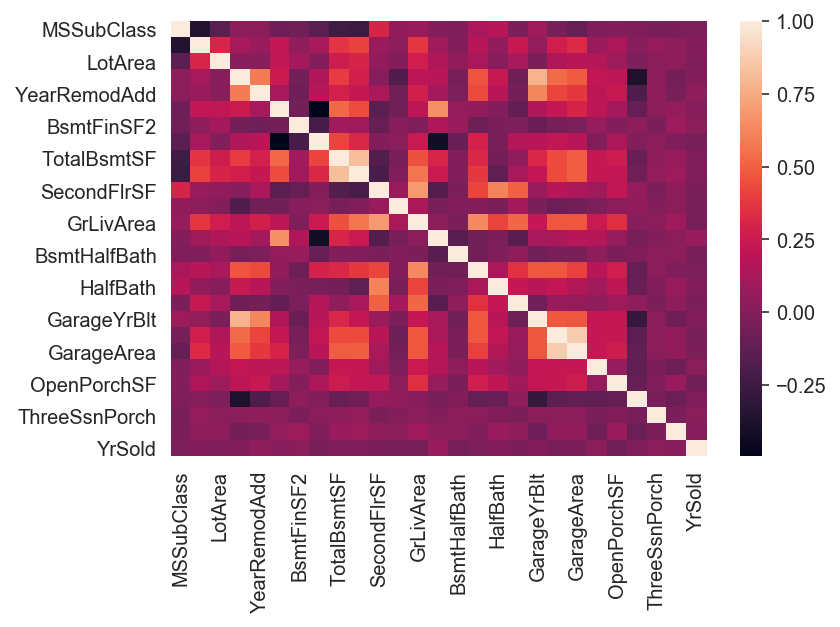

In [26]:
sns.heatmap(fixed_features.corr())

In [27]:
renovateable_features = house.loc[:,['HouseStyle','OverallQual','OverallCond','RoofStyle','RoofMatl', 
'MasVnrType', 'MasVnrArea','ExterQual','ExterCond','BsmtCond','BsmtFinType1', 'BsmtFinType2',
'Heating', 'HeatingQC','CentralAir', 'Electrical','KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
'Functional', 'Fireplaces',  'GarageFinish','GarageQual', 'GarageCond', 'PavedDrive','PoolArea',
'MoSold', 'YrSold', 'SaleType','SaleCondition']]

len(renovateable_features.columns)

30

# Visualization

#### a) Univariate Analysis
Visualizing all numeric data and their distributions 

/Users/garimamahajan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


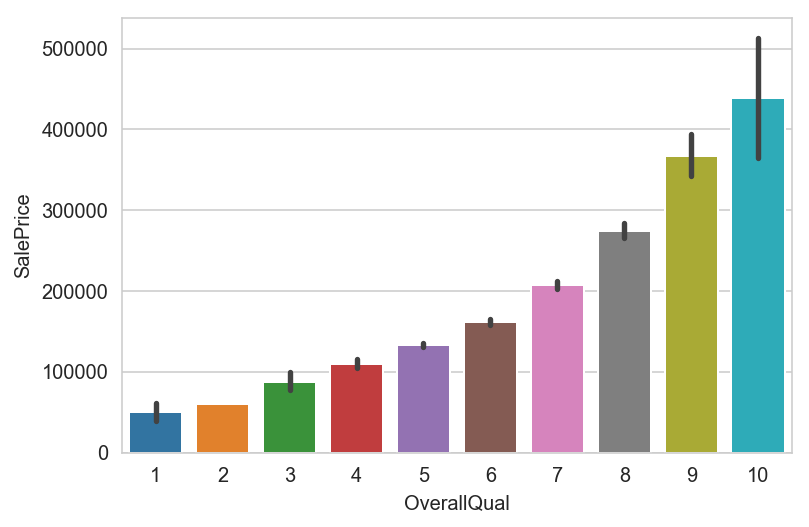

In [28]:
sns.barplot(x='OverallQual', y='SalePrice' , data= house);

Higher the quality of the house, higher the Price. Valid Point.

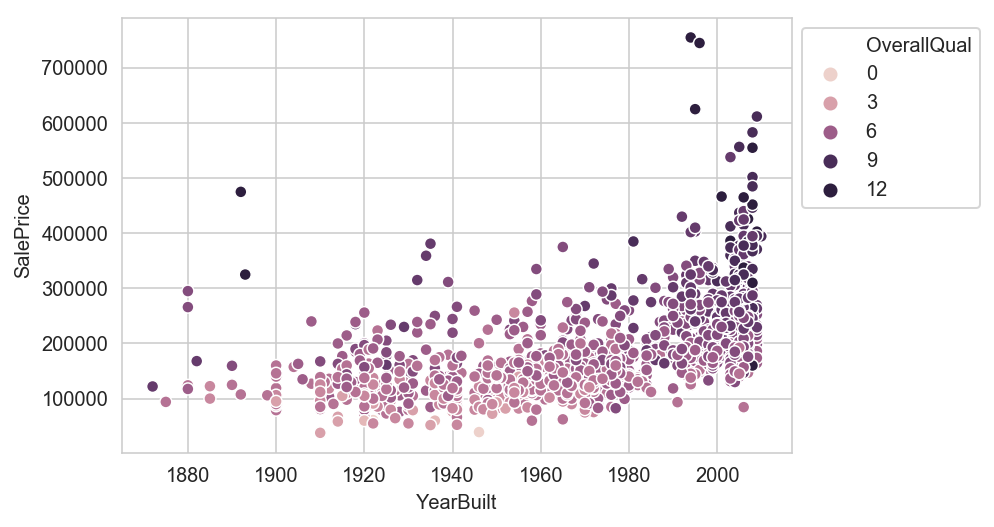

In [29]:
sns.scatterplot(x ='YearBuilt', y='SalePrice' , data = house, hue='OverallQual')
plt.legend(bbox_to_anchor= (1,1))

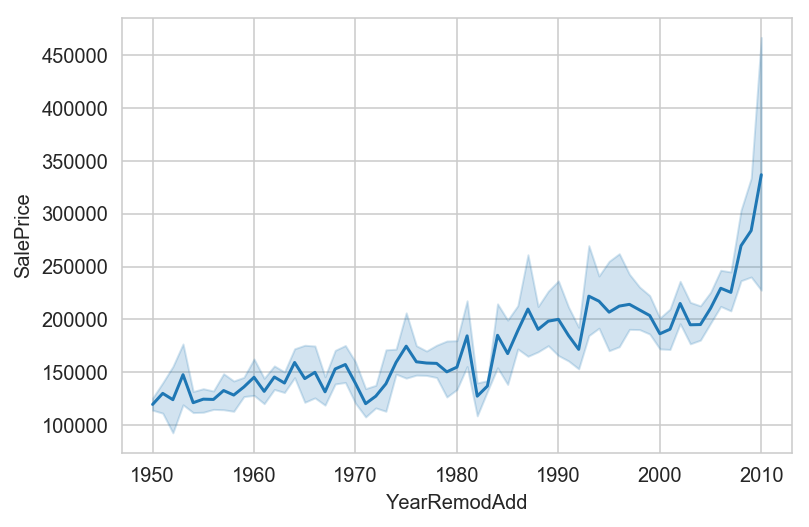

In [30]:
sns.lineplot(x ='YearRemodAdd', y='SalePrice' , data = house)

The SalePrice is high for house that are remodeled after 2008.

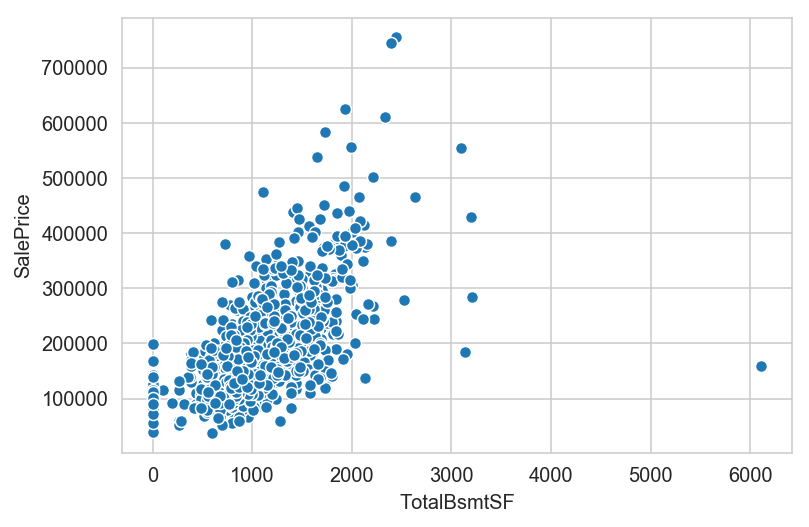

In [31]:
sns.scatterplot(x ='TotalBsmtSF', y='SalePrice' , data = house) 

The SalePrice for 1000-2000 Total Basement Sq ft is between 100K and 400K but if increase in Sq_ft leads to increase in price for few cases.

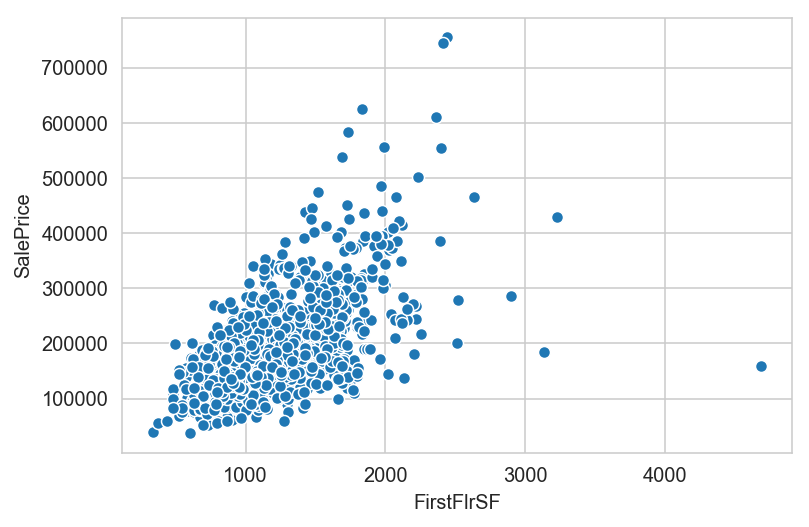

In [32]:
sns.scatterplot(x ='FirstFlrSF', y='SalePrice' , data = house)

The SalePrice gradually increases with increase in Sq ft.

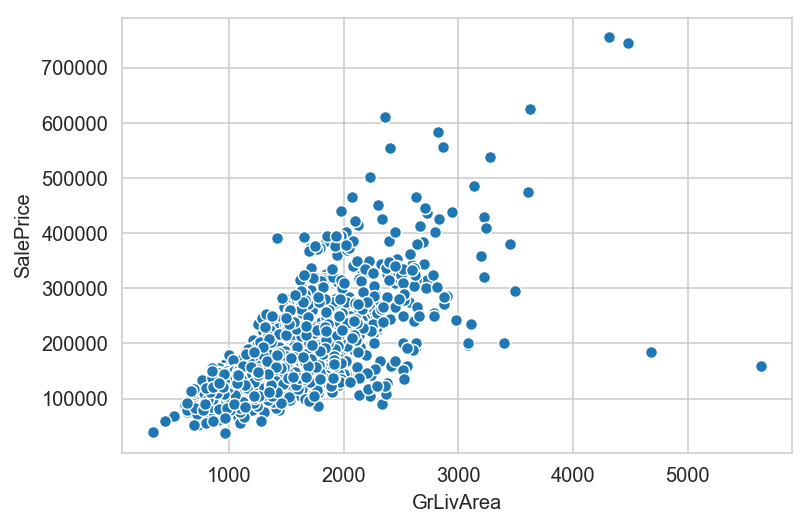

In [33]:
sns.scatterplot(x ='GrLivArea', y='SalePrice' , data = house)

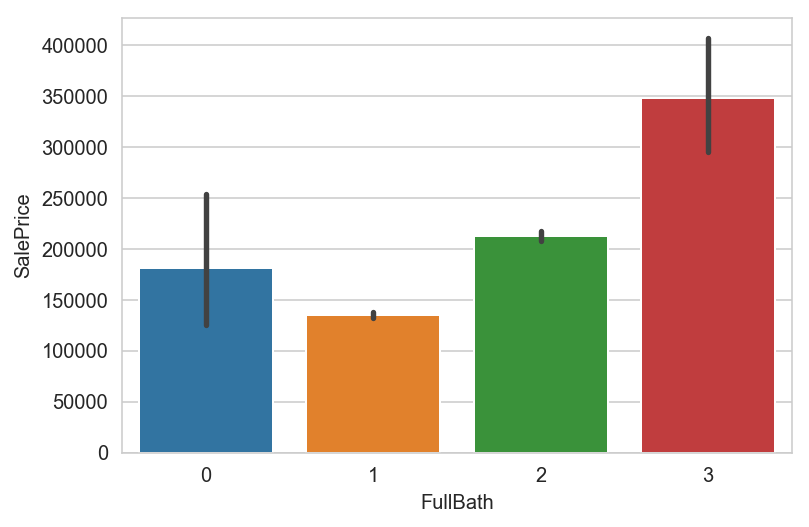

In [34]:
sns.barplot(x ='FullBath', y='SalePrice' , data = house)

SalesPrice is high if the no. of Bathrooms

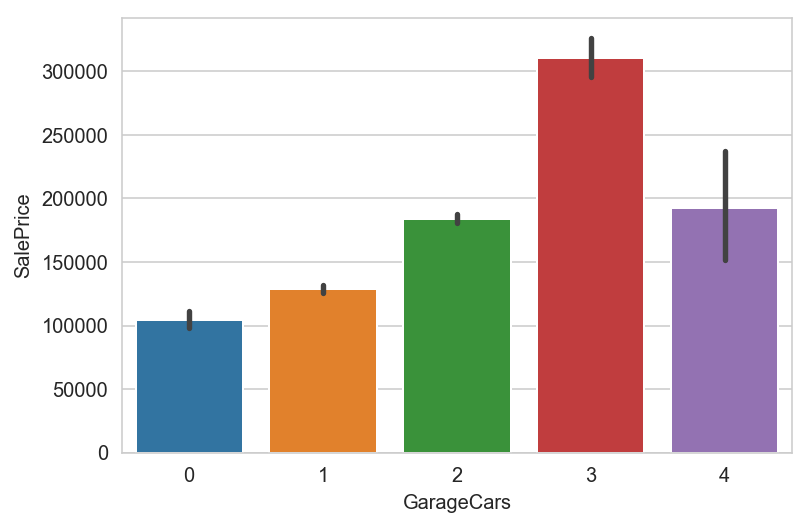

In [35]:
sns.barplot(x ='GarageCars', y='SalePrice' , data = house)

Now a days everyone in the family owns a car and thus house with three car spaces have a high Saleprice

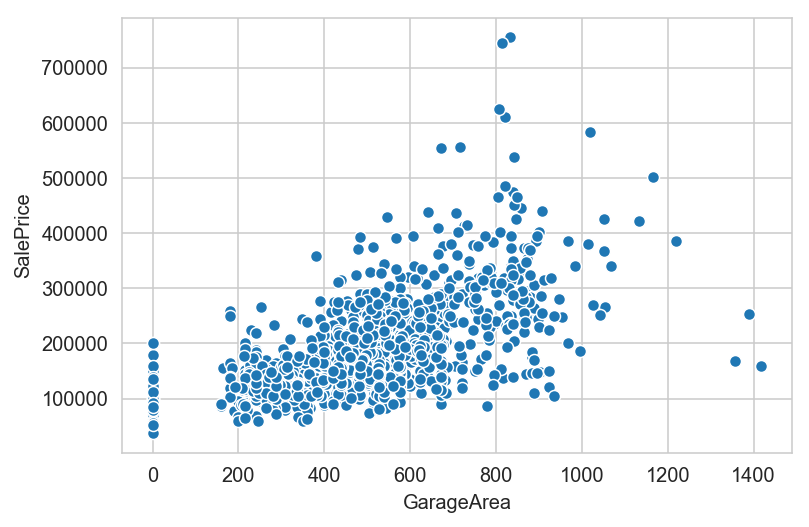

In [36]:
sns.scatterplot(x ='GarageArea', y='SalePrice' , data = house)

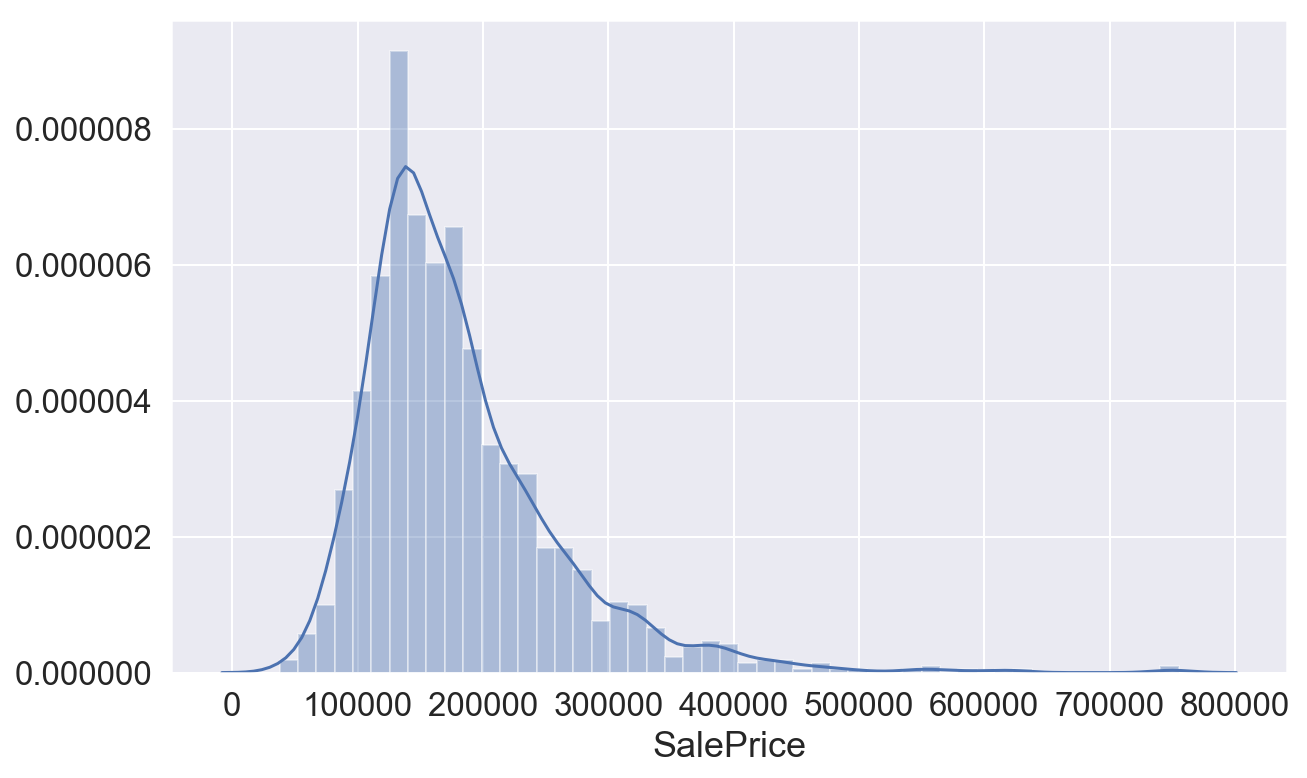

In [37]:
fig = plt.figure(figsize=(10,6))
sns.set(font_scale=1.5)

sns.distplot(house['SalePrice'])

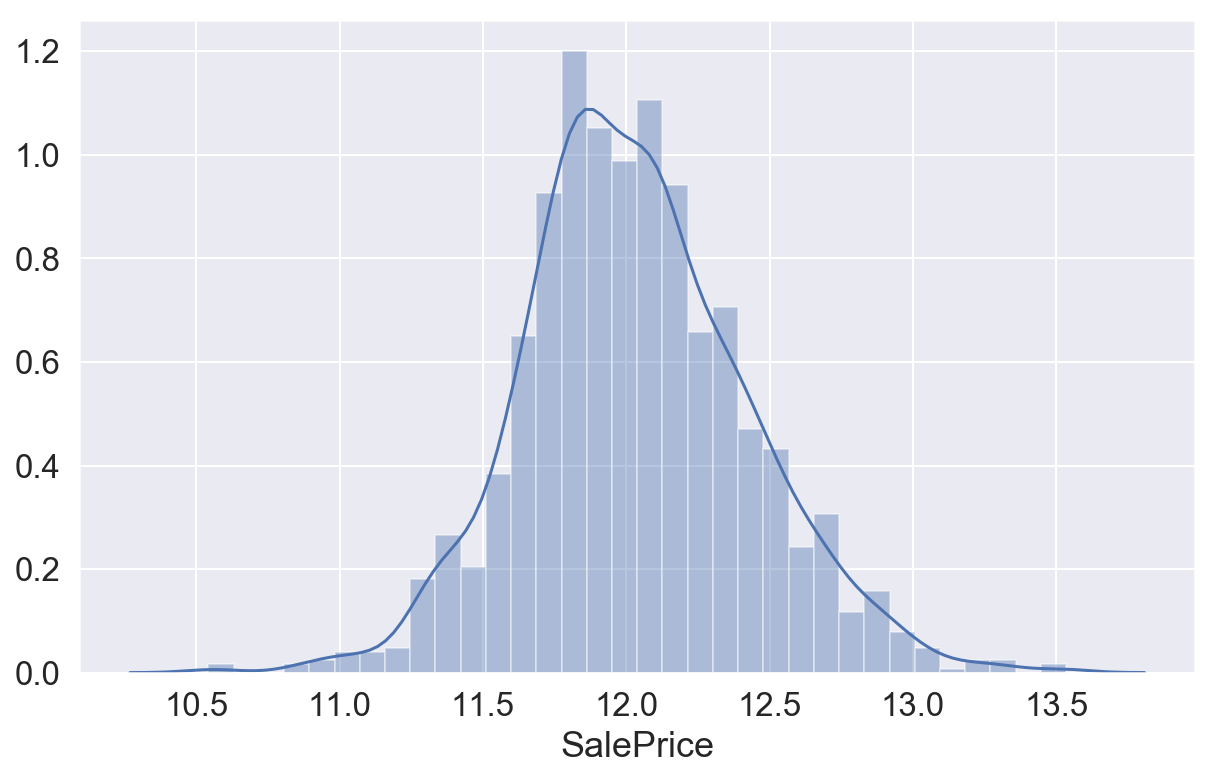

In [38]:
#log Transformation of the SalePrice thats our target.
ax= plt.subplots(figsize=(10,6))
sns.distplot(np.log(house['SalePrice']))

#### b) Correlation Matrix

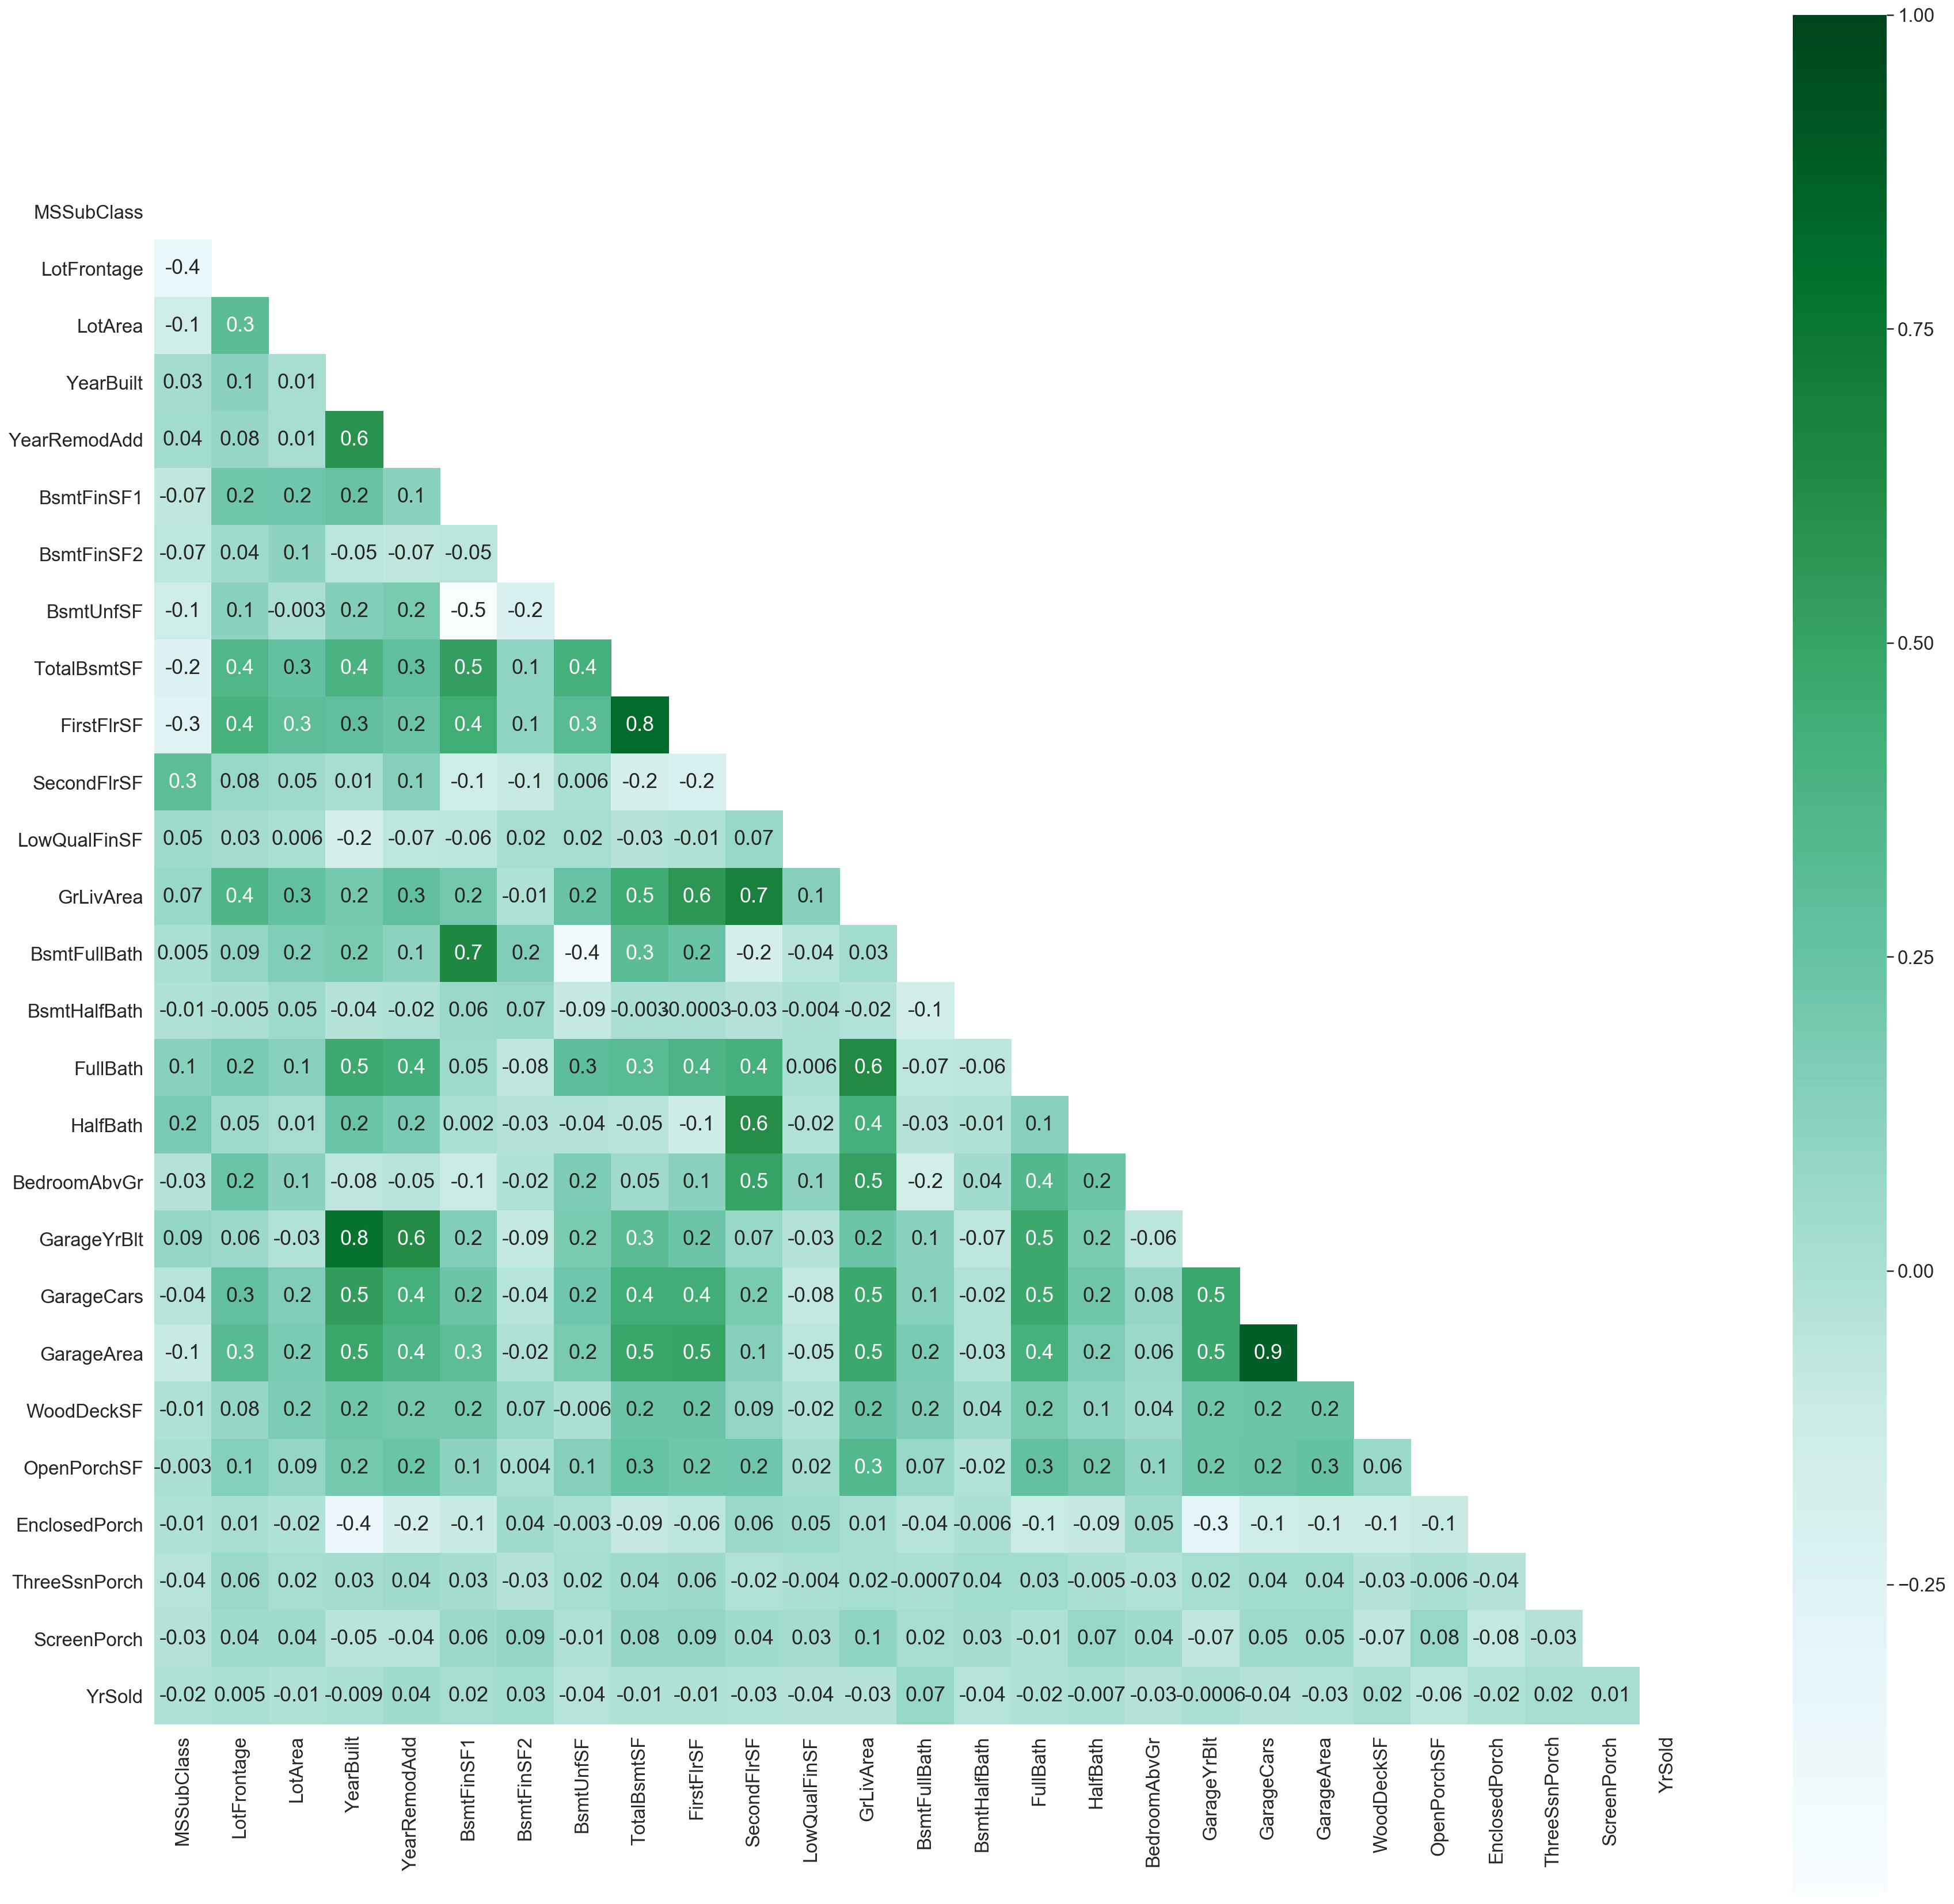

In [39]:
# Calculate and plot
plt.figure(figsize= (30,30))
mask = np.zeros_like(fixed_features.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(fixed_features.corr(),cmap='BuGn', mask=mask, square=True,annot=True, fmt='.1g')

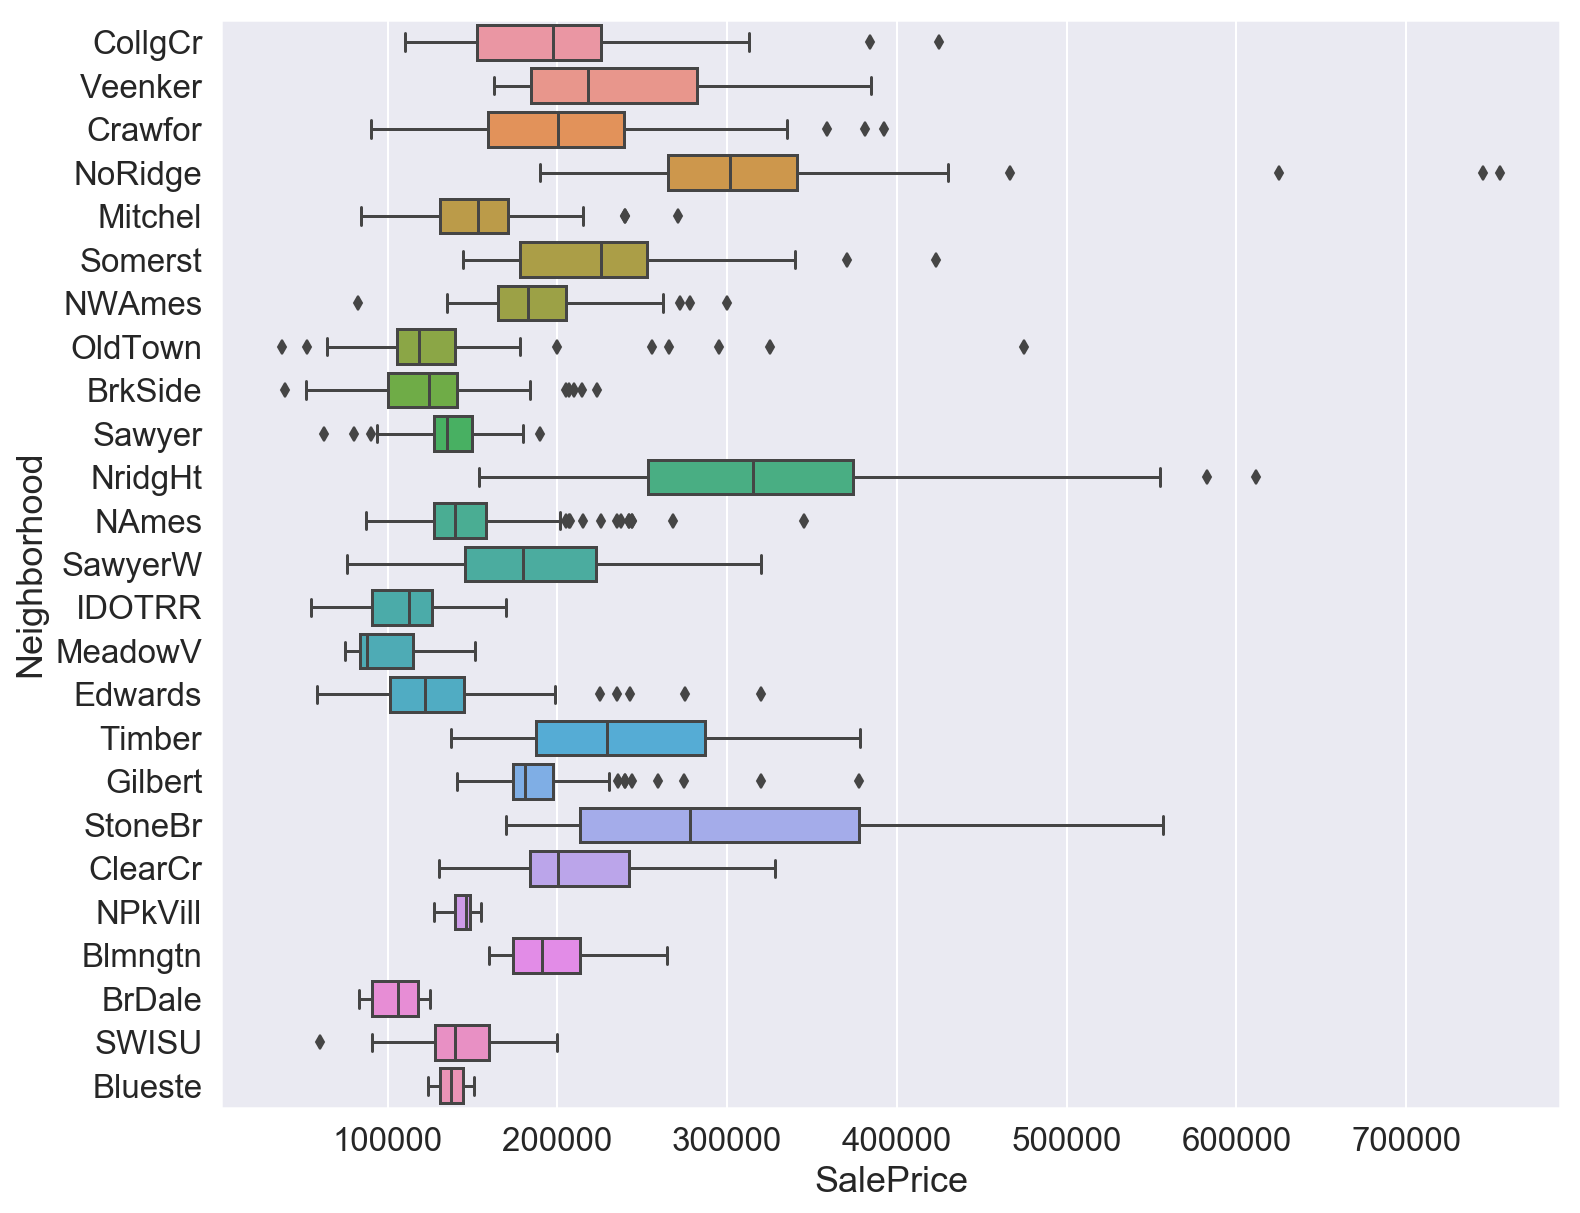

In [40]:
plt.figure(figsize= (12,10))
sns.set_style('darkgrid')
g=sns.boxplot(y = 'Neighborhood', x= 'SalePrice', data= house)

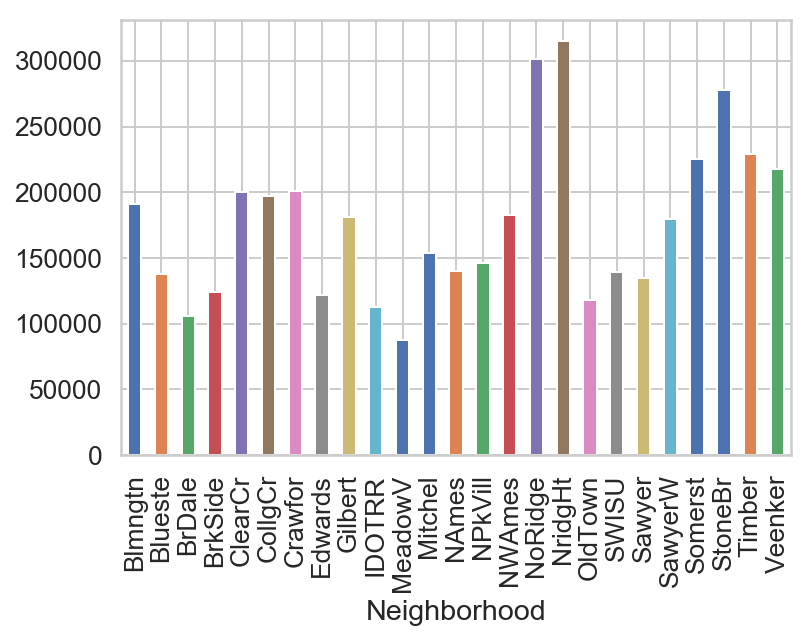

In [44]:
saleprice_neigh= house.groupby('Neighborhood')['SalePrice'].median()
saleprice_neigh.plot(kind='bar',)

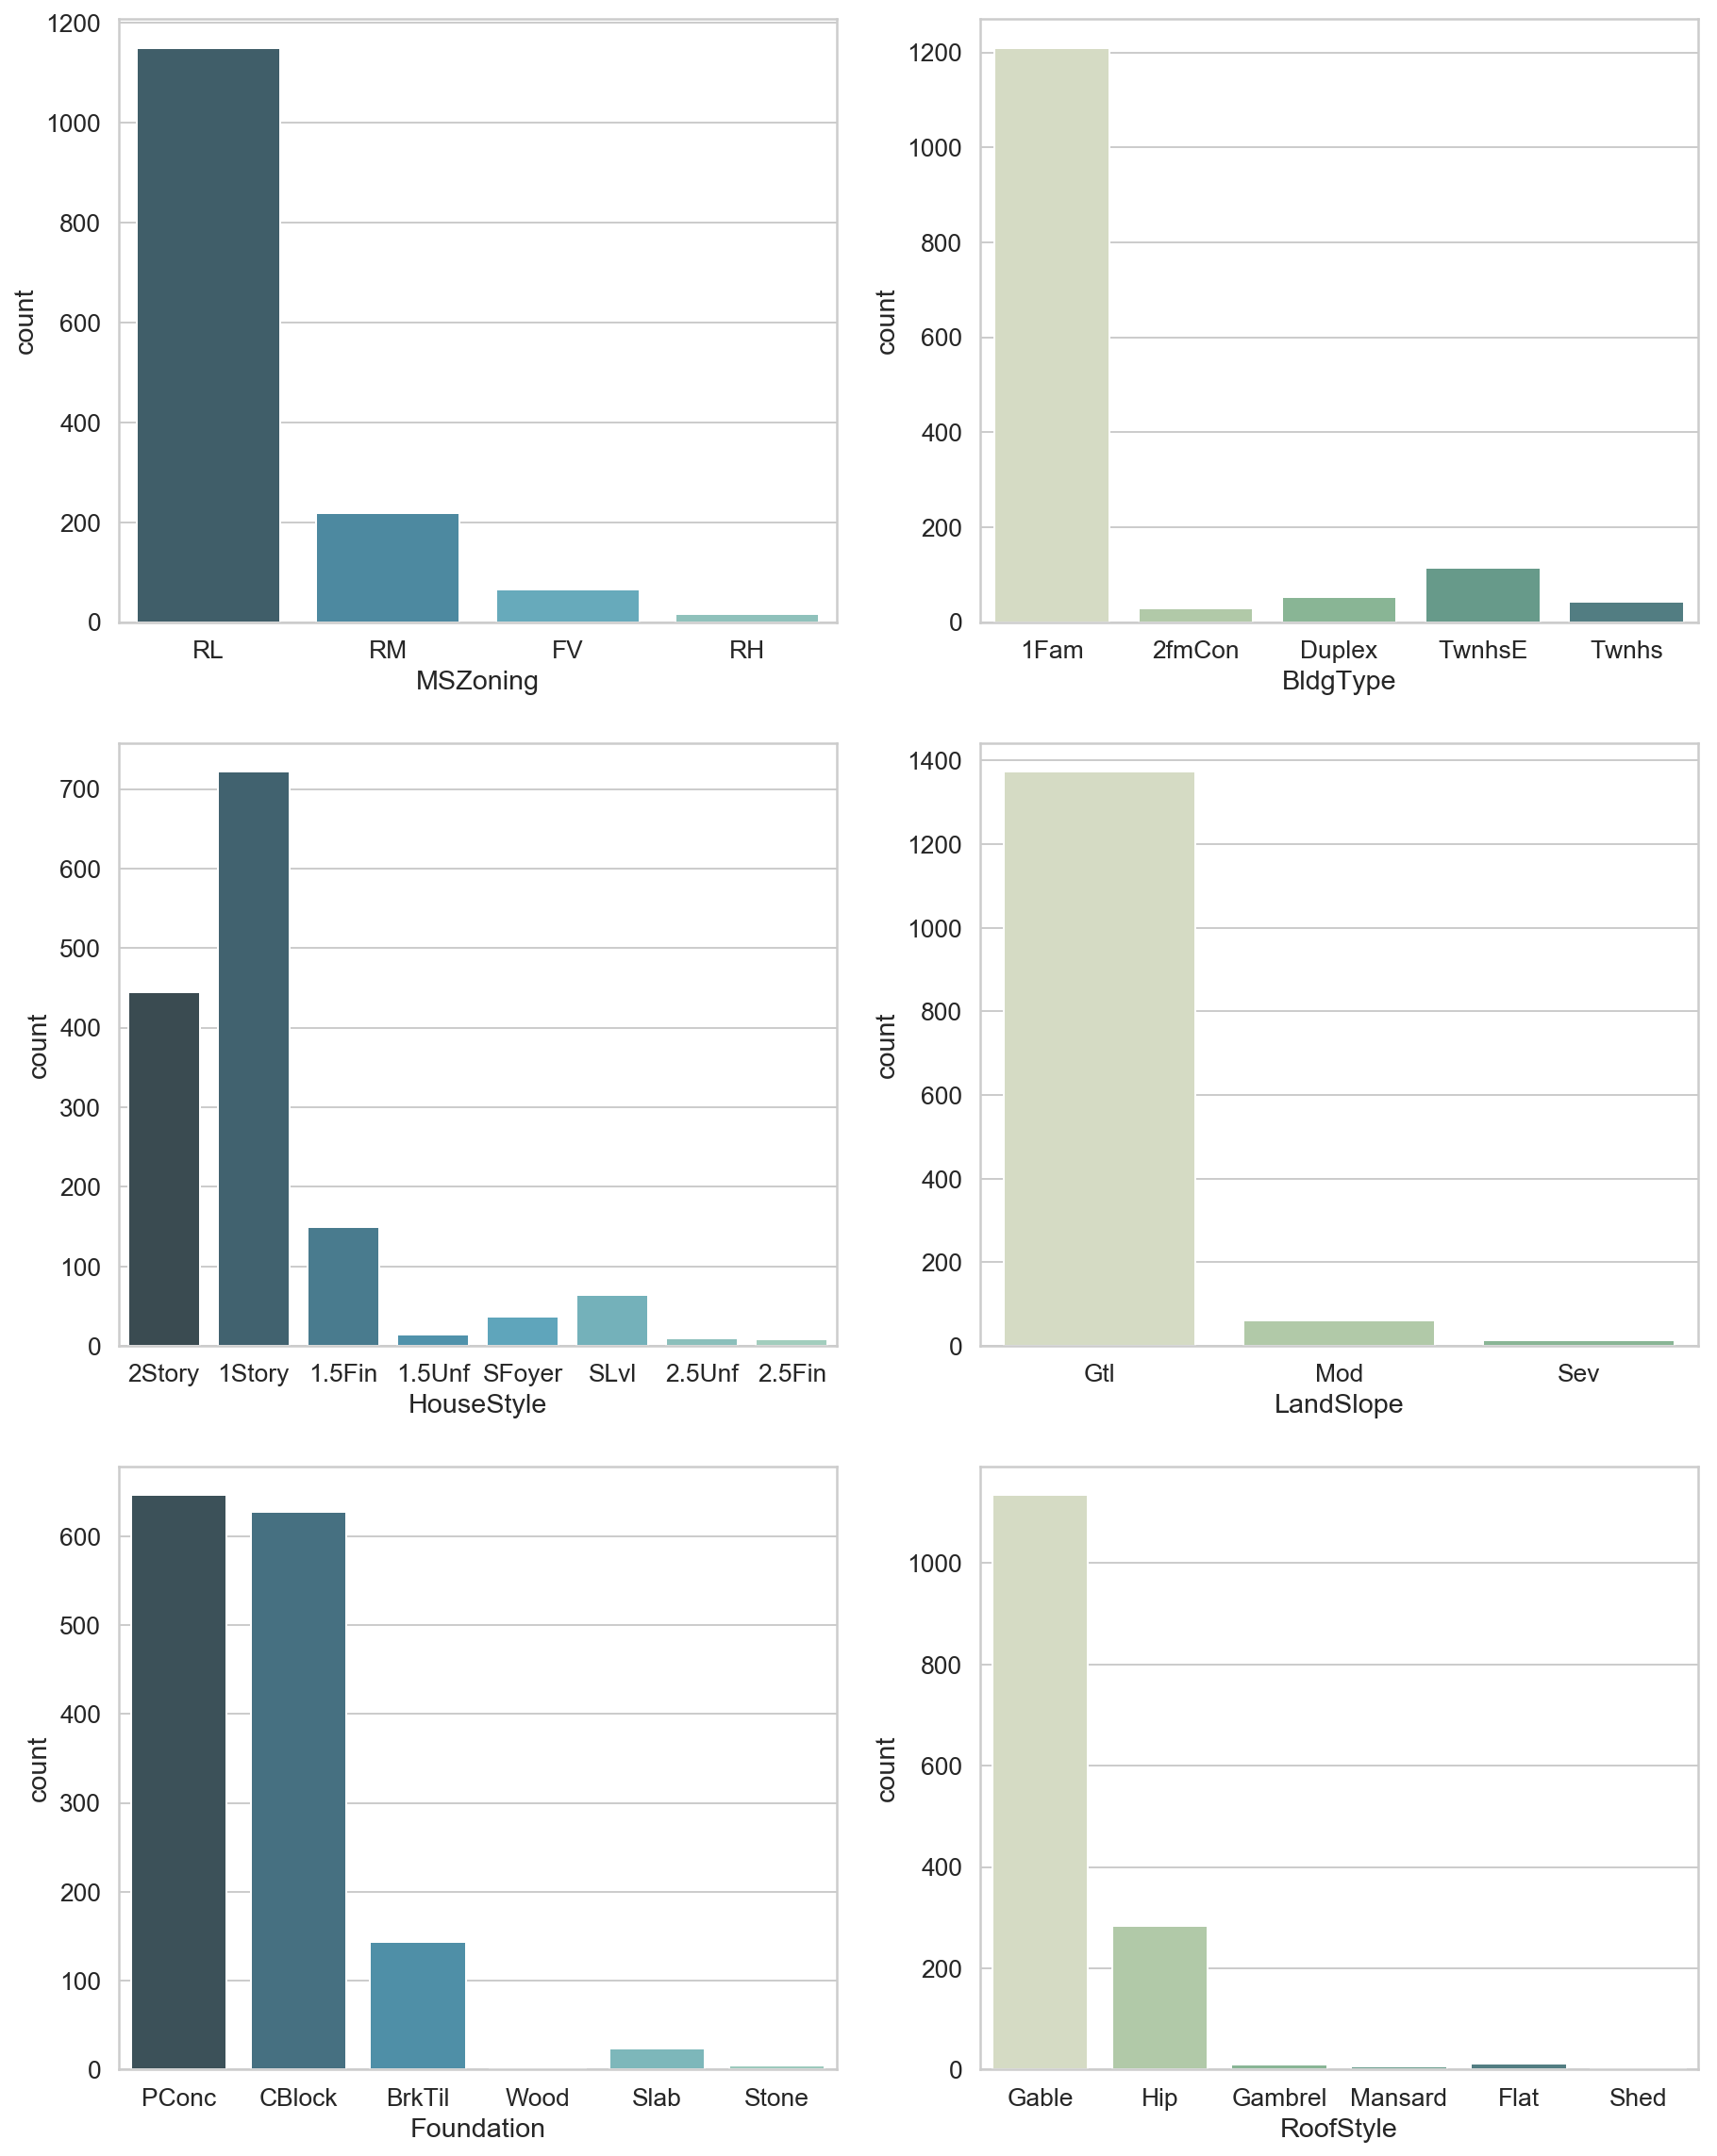

In [45]:
sns.set(style="whitegrid", color_codes=True, font_scale=1.2)
c_palette = sns.cubehelix_palette(8, start=.5, rot=-.75)
fig, ax = plt.subplots(3,2, figsize=(15,20))
sns.countplot(x = 'MSZoning', data=house, ax=ax[0,0], palette='GnBu_d');
sns.countplot(x = 'BldgType', data=house, ax=ax[0,1], palette=c_palette);
sns.countplot(x = 'HouseStyle', data=house, ax=ax[1,0], palette='GnBu_d');
sns.countplot(x = 'LandSlope', data=house, ax=ax[1,1], palette=c_palette);
sns.countplot(x = 'Foundation', data=house, ax=ax[2,0], palette='GnBu_d');
sns.countplot(x = 'RoofStyle', data=house, ax=ax[2,1], palette=c_palette);

# Model fitting


In [46]:
fixed_features.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'YearBuilt',
       'YearRemodAdd', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'GarageType', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ThreeSsnPorch', 'ScreenPorch', 'YrSold'],
      dtype='object')

In [47]:
#fixed_features
fixed_features.columns[fixed_features.dtypes=='object'].values

array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'GarageType'], dtype=object)

#### Creating the dummies for Categorical Variable

In [48]:
house_fxd = pd.get_dummies(fixed_features, 
                            columns= ['MSZoning','Street', 'LotShape', 'LandContour','Utilities','LotConfig',
                                         'LandSlope', 'Neighborhood','Condition1','Condition2', 'BldgType',
                                         'Foundation','BsmtQual','BsmtExposure','GarageType'], drop_first= True)

#### Splitting X_train and X_test

In [49]:
X_train = house_fxd[house_fxd['YrSold'] < 2010]
X_test = house_fxd[house_fxd['YrSold'] >= 2010]

#### Splitting y_train and y_test

In [50]:
y_train = house.loc[house['YrSold'] < 2010, 'SalePrice']
y_test= house.loc[house['YrSold'] >= 2010, 'SalePrice']

In [51]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1277, 106)
(1277,)
(172, 106)
(172,)


#### Standardizing the Data

In [52]:
ss= StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

/Users/garimamahajan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/garimamahajan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/garimamahajan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


#### 1.1 Fitting a Linear Model

In [53]:
lr = LinearRegression()
linear_model = lr.fit(X_train,y_train)

In [54]:
yhat_test = linear_model.predict(X_test)

In [55]:
yhat_train = linear_model.predict(X_train)

In [56]:
print("Training set score: {:.4f}".format(linear_model.score(X_train,y_train)))
print("Test set score: {:.4f}".format(linear_model.score(X_test,y_test)))

Training set score: 0.8629
Test set score: 0.8671


In [57]:
# ideal scenario 

#### Residual Plot

/Users/garimamahajan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


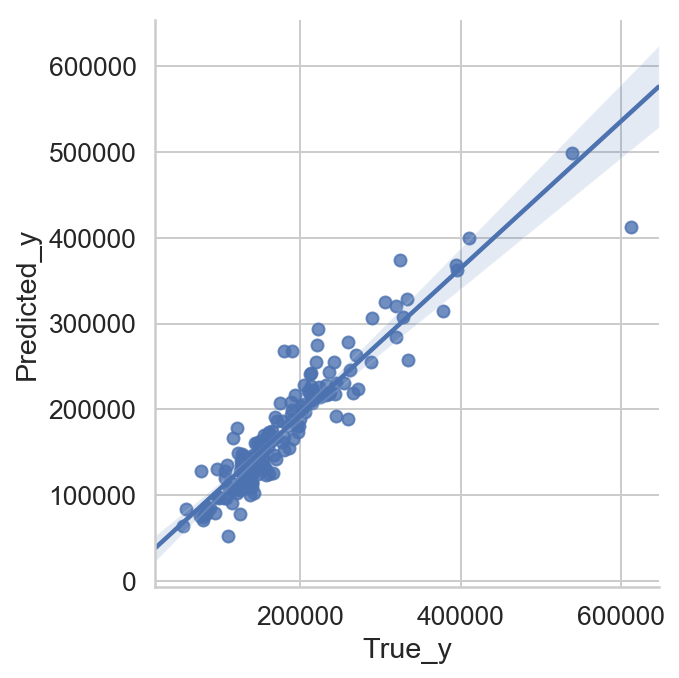

In [58]:
residual_plot= pd.DataFrame(list(zip(yhat_test,y_test)), columns= ['Predicted_y','True_y'])
sns.lmplot(x = 'True_y', y= 'Predicted_y', data= residual_plot );

#### After log of SalePrice

In [59]:
y_train_log = np.log(house.loc[house['YrSold'] < 2010, 'SalePrice'])
y_test_log = np.log(house.loc[house['YrSold'] >= 2010, 'SalePrice'])

In [60]:
lr = LinearRegression()
linear_model = lr.fit(X_train,y_train_log)

In [61]:
yhat_train_log = linear_model.predict(X_train)

In [62]:
yhat_test_log = linear_model.predict(X_test)

In [63]:
print("Training set score: {:.4f}".format(linear_model.score(X_train,y_train_log)))
print("Test set score: {:.4f}".format(linear_model.score(X_test,y_test_log)))

Training set score: 0.8812
Test set score: 0.8809


#### Residual Plot

/Users/garimamahajan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


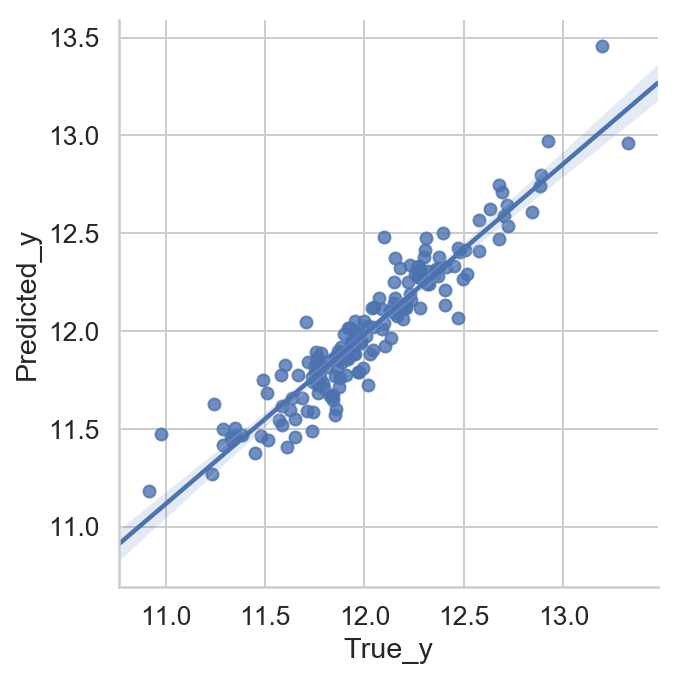

In [64]:
residual_plot= pd.DataFrame(list(zip(yhat_test_log,y_test_log)), columns= ['Predicted_y','True_y'])
sns.lmplot(x = 'True_y', y= 'Predicted_y', data= residual_plot );

#### Lasso Regression

In [65]:
mdl= Lasso(alpha=0.0001,max_iter=1000)
lasso = mdl.fit(X_train,y_train_log)

In [66]:
print("Training set score: {:.3f}".format(lasso.score(X_train,y_train_log)))
print("Test set score: {:.3f}".format(lasso.score(X_test,y_test_log)))
print("No.of Features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.881
Test set score: 0.881
No.of Features used: 102


#### Ridge Regression 

In [67]:
mdl= Ridge(alpha=0.01)
ridge = mdl.fit(X_train,y_train_log)

In [68]:
print("Training set score: {:.4f}".format(ridge.score(X_train,y_train_log)))
print("Test set score: {:.4f}".format(ridge.score(X_test,y_test_log)))
print("No.of Features used: {}".format(np.sum(ridge.coef_ != 0)))

Training set score: 0.8812
Test set score: 0.8809
No.of Features used: 106


#### Checking Coefficients by ridge

In [80]:
X_train = house_fxd[house_fxd['YrSold'] < 2010]
ridge_coefs = pd.DataFrame(list(zip(X_train.columns,ridge.coef_)), columns=['Variables','Coef'])
ridge_coefs = ridge_coefs.loc[(ridge_coefs['Coef'] != 0)]

In [81]:
ridge_coefs['Coef_abs'] = ridge_coefs['Coef'].abs()
ridge_coefs.sort_values('Coef_abs', ascending=False).head(10)

,Variables,Coef,Coef_abs
100,GarageType_Attchd,0.116954,0.116954
104,GarageType_Detchd,0.091442,0.091442
12,GrLivArea,0.078311,0.078311
9,FirstFlrSF,0.056366,0.056366
102,GarageType_BuiltIn,0.054756,0.054756
19,GarageCars,0.052438,0.052438
95,BsmtQual_TA,-0.052167,0.052167
4,YearRemodAdd,0.051722,0.051722
3,YearBuilt,0.047362,0.047362
10,SecondFlrSF,0.044183,0.044183


#### Checking for Coeffients by Lasso

In [83]:
X_train = house_fxd[house_fxd['YrSold'] < 2010]
lasso_coefs = pd.DataFrame(list(zip(X_train.columns,lasso.coef_)), columns=['Variables','Coef'])
lasso_coefs = lasso_coefs.loc[(lasso_coefs['Coef'] != 0)]

In [84]:
lasso_coefs['Coef_abs'] = lasso_coefs['Coef'].abs()
lasso_coefs.sort_values('Coef_abs', ascending=False).head(10)

,Variables,Coef,Coef_abs
100,GarageType_Attchd,0.098196,0.098196
104,GarageType_Detchd,0.074259,0.074259
12,GrLivArea,0.072483,0.072483
9,FirstFlrSF,0.061671,0.061671
19,GarageCars,0.053004,0.053004
4,YearRemodAdd,0.051806,0.051806
95,BsmtQual_TA,-0.051127,0.051127
10,SecondFlrSF,0.050009,0.050009
3,YearBuilt,0.048724,0.048724
102,GarageType_BuiltIn,0.045471,0.045471


#### Top estimators of price:
Garagae Type, First and Second Floor Sq_ft, GrLivArea, Garage_builtin, YearBuilt,YearRemodAdd

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [85]:
# A:
renovateable_features.columns

Index(['HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtCond',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolArea', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [86]:
renovateable_features.columns[renovateable_features.dtypes=='object']

Index(['HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual',
       'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

#### Creating dummies for renovatable features

In [87]:
house_renot = pd.get_dummies(renovateable_features, 
                               columns= ['HouseStyle', 'RoofStyle', 'RoofMatl', 
       'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],drop_first=True) 

In [88]:
col_data=list()
for name in house_renot.columns:
    col_data.append([name,house_renot[name].value_counts().iloc[0]*100/house_renot[name].count()])
    col_data.sort(key=lambda x:x[1],reverse=True)
col_data  

[['RoofMatl_Membran', 99.93098688750862],
 ['RoofMatl_Metal', 99.93098688750862],
 ['RoofMatl_Roll', 99.93098688750862],
 ['ExterCond_Po', 99.93098688750862],
 ['HeatingQC_Po', 99.93098688750862],
 ['Electrical_Mix', 99.93098688750862],
 ['Functional_Sev', 99.93098688750862],
 ['RoofStyle_Shed', 99.86197377501725],
 ['BsmtCond_Po', 99.86197377501725],
 ['Heating_OthW', 99.86197377501725],
 ['SaleType_Con', 99.86197377501725],
 ['Electrical_FuseP', 99.79296066252589],
 ['GarageQual_Po', 99.79296066252589],
 ['SaleType_Oth', 99.79296066252589],
 ['Heating_Wall', 99.72394755003451],
 ['SaleType_CWD', 99.72394755003451],
 ['SaleCondition_AdjLand', 99.72394755003451],
 ['RoofMatl_WdShake', 99.65493443754313],
 ['Functional_Maj2', 99.65493443754313],
 ['SaleType_ConLI', 99.65493443754313],
 ['SaleType_ConLw', 99.65493443754313],
 ['RoofMatl_WdShngl', 99.58592132505176],
 ['PoolArea', 99.51690821256038],
 ['RoofStyle_Mansard', 99.51690821256038],
 ['Heating_Grav', 99.51690821256038],
 ['Garag

In [89]:
# A:
house_renot.shape

(1449, 106)

In [90]:
# house_renot.skew()

####  Fitting a Linear Model on renovatable features

In [91]:
X_train_r = house_renot[house_renot['YrSold'] < 2010]
X_test_r = house_renot[house_renot['YrSold'] >= 2010]

In [94]:
ss= StandardScaler()
X_train_r = ss.fit_transform(X_train_r)
X_test_r = ss.transform(X_test_r)

/Users/garimamahajan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/garimamahajan/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/garimamahajan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [95]:
y_train_r = y_train - yhat_train
y_test_r  = y_test - yhat_test

In [96]:
lm = LinearRegression()
linear = lm.fit(X_train_r,y_train_r)

In [97]:
yhat_train_r = linear.predict(X_train_r)

In [98]:
yhat_test_r = linear.predict(X_test_r)

In [99]:
print("Training set score: {:.4f}".format(mt.r2_score(y_train_r,yhat_train_r)))
print("Test set score: {:.4f}".format(mt.r2_score(y_test_r,yhat_test_r)))

Training set score: 0.3169
Test set score: -1537437121538660096.0000


As per our above result we can see that the model is overfitting to our training dataset so simple linear model is not that good.

#### Lasso Regression


In [132]:
mdl= Lasso(alpha=20,max_iter=1000)
lasso = mdl.fit(X_train_r,y_train_r)

/Users/garimamahajan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [148]:
print("Training set score: {:.2f}".format(lasso.score(X_train_r,y_train_r)))
print("Test set score: {:.2f}".format(lasso.score(X_test_r,y_test_r)))
print("No.of Features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.32
Test set score: 0.17
No.of Features used: 96


Tried using Lasso but for the renovatable features , Lasso dint work good as over model is overfitting if alpha value 
is increased the model does not show results.

#### Ridge Regression

In [149]:
mdl= Ridge(alpha=10,solver='sag')
ridge1 = mdl.fit(X_train_r,y_train_r)
yhat_train_ridge= mdl.predict(X_train_r)
yhat_test_ridge = mdl.predict(X_test_r)

In [150]:
print("Training set score: {:.2f}".format(ridge1.score(X_train_r,y_train_r)))
print("Test set score: {:.2f}".format(ridge1.score(X_test_r,y_test_r)))
print("No.of Features used: {}".format(np.sum(ridge1.coef_ != 0)))

Training set score: 0.29
Test set score: 0.15
No.of Features used: 105


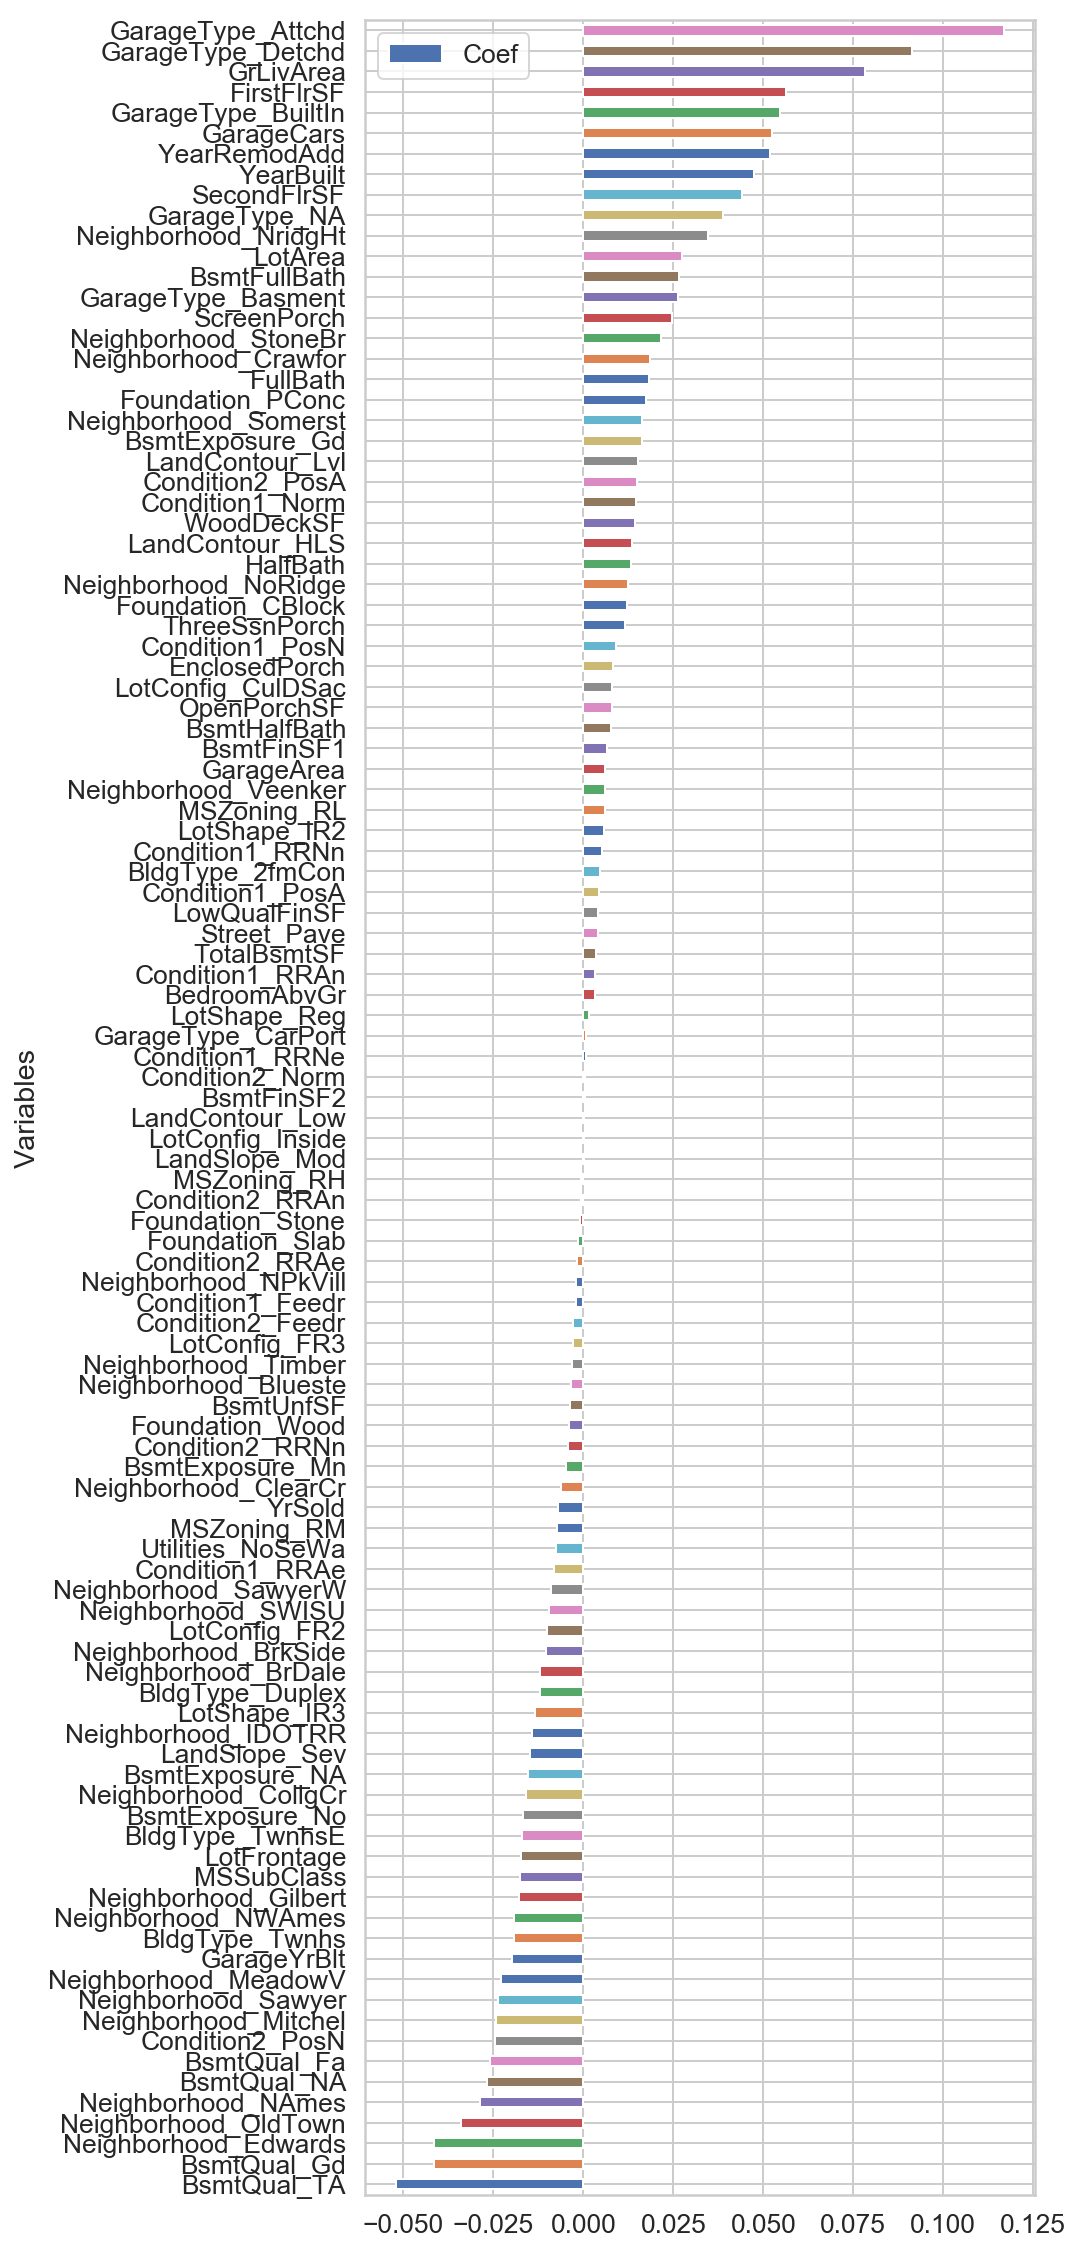

In [153]:
# ridge_coefs = pd.DataFrame(list(zip(X_train_r.columns,ridge1.coef_)),columns=['Variables','Coef'])
ridge_coefs = ridge_coefs.loc[(ridge_coefs['Coef'] != 0)]
ridge_coefs.sort_values('Coef', ascending=True).plot(x='Variables',y='Coef',figsize=(6,20), kind='barh')

In [152]:
ridge_coefs['Coef_abs'] = ridge_coefs['Coef'].abs()
ridge_coefs.sort_values('Coef_abs', ascending=False).head(10)

,Variables,Coef,Coef_abs
100,GarageType_Attchd,0.116954,0.116954
104,GarageType_Detchd,0.091442,0.091442
12,GrLivArea,0.078311,0.078311
9,FirstFlrSF,0.056366,0.056366
102,GarageType_BuiltIn,0.054756,0.054756
19,GarageCars,0.052438,0.052438
95,BsmtQual_TA,-0.052167,0.052167
4,YearRemodAdd,0.051722,0.051722
3,YearBuilt,0.047362,0.047362
10,SecondFlrSF,0.044183,0.044183


#### fixed_residuals mean and median

In [154]:
fixed_residuals= y_test - yhat_test
print('residuals mean from fixed features: ', fixed_residuals.mean())
print('residuals median from fixed features: ',fixed_residuals.median())

residuals mean from fixed features:  4210.557003735445
residuals median from fixed features:  3037.1407439305403


#### renot_residuals mean and median

In [155]:
renot_residuals = y_test_r - yhat_test_ridge
print('residuals mean from renovatable features: ', renot_residuals.mean())
print('residuals median from renovatable features: ',renot_residuals.median())

residuals mean from renovatable features:  3634.4925788506016
residuals median from renovatable features:  3813.2032261590457


In [156]:
print('mean difference b/w fixed and renovatable features:', (fixed_residuals.mean()-renot_residuals.mean()))
print('median difference b/w fixed and renovatable features:', (fixed_residuals.median()-renot_residuals.median()))

mean difference b/w fixed and renovatable features: 576.064424884843
median difference b/w fixed and renovatable features: -776.0624822285054
